# Gaussian Processes and Gaussian Process Regression

This notebook will walk through the key mathematical details required to understand what a Gaussian Process is and how Gaussian Process Regression works.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom, beta

np.random.seed(15)

sns.set(rc = {'figure.figsize':(12,5)})

Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a Gaussian Process is fully specified by a mean function and a covariance function

$$p(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

For example, take the mean function equal to 0 and the squared exponential covariance function

$$m(x) = 0$$
$$k(x,x') = \theta_1 \cdot exp \left(- \frac{\theta_2}{2}(x - x')^2 \right)$$

It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function. It is common to take a mean function of 0 as the prior and rely completely on the covariance function for learning.

Let's walk through a Gaussian Process Regression example using the prior GP we just defined above. First we define the mean and covariance functions. We will start with hyperpareters $\sigma_0 = 1$, $\sigma_1=10$.

In [2]:
xpts = np.arange(-3, 3, step=0.01)

mean_prior = [0 for x in xpts]

def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x,y)**2)

theta = [1, 10]

sigma_0 = exponential_cov(0, 0, theta)

print(sigma_0)

1.0


Based on the prior and hyperparameters we chose, the mean at every point in our domain is 0 and the standard deviatoin at every point in our domain is 1. It is important to remember that each value on the $x$ axis has a corresponding normal distribution. That is, the value $x = 1$ has a normal distribution represented by $y$ values along the $y$ axis. So does $x = \pi$, $x = e$, and $x = -1.23$, etc. This GP represents uncountbaly infinite normal distributions. That being said, we only need to store in the computer those of which we want to compute.

Below we plot our GP prior

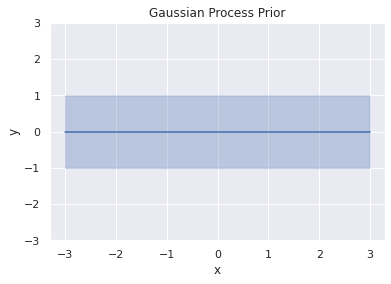

In [3]:
plt.plot(xpts, mean_prior, label="mean");
stdev_plus = [x + sigma_0 for x in mean_prior]
stdev_minus = [x - sigma_0 for x in mean_prior]
plt.fill_between(xpts, stdev_plus, color="b", alpha=0.3);
plt.fill_between(xpts, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Prior");

We have our first Gaussian Process! Lets take a sample at a random point, say 1, to make our first observation. The default values for np.random.normal() are a mean of 0 and a standard deviation of 1, so that will work as our first sample.

In [4]:
x = [1.]
y = [np.random.normal()]
print(f"x: {x}")
print(f"y: {y}")

# New sigma
sigma_1 = exponential_cov(x, x, theta)
print(f"sigma_1: {sigma_1}")

x: [1.0]
y: [-0.3123284815435444]
sigma_1: [[1.]]


Now we have our first observation, $(1, -0.312)$. From here, we will need to use some conditioning formulas for multivariate Gaussian Distributions so we can condition our Gaussian Process prior on this observation and obtain our Posterior. The conditioning property of multivariate Gaussian Distributions gives us the following mean and covariance fucntions for $p(x|y)$

$$\mu = \mu_x + \Sigma_{xy} \Sigma_y^{-1}(y - \mu_y)$$
$$\sigma = \Sigma_x - \Sigma_{xy} \Sigma_y^{-1} \Sigma_{yx}$$

Our first oberservation is $(1, -0.312)$. We will need to compute the resulting normal distribution at all the remaining points in xpts. To help us understand how that calculation works, let us start with a single unkown point from xpts, say $x=0.7$. We want to know the probability distribution for $y$ at $x=0.7$ given the data we know, by using the formulas above. Let's take $x_0 = 1$ and $x_1 = 0.7$.

Remember! Here $x_0$ and $x_1$ represent normal distributions, it is confusing to keep track of this, I know. Moreover, $x_0$ has been observed and no longer represents a normal distribution, we take the value of $-0.312$ for $x_0$. (yikes)

$p(x_1 \; | \; x_0 = -0.312)$

$\mu = \mu_{x_1} + \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} (x_0 - \mu_{x_0})$

$\sigma = \Sigma_{x_1} - \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} \Sigma_{x_0 x_1}$

Let's calculate this!

In [5]:
# We will need this inverse in our calculations
x_0 = x[0]
y_0 = y[0]

x_1 = 0.7

sigma_inv = np.linalg.inv([[exponential_cov(x_1, x_1, theta)]])

mu = 0 + np.dot([[exponential_cov(0.7, 1, theta)]], sigma_inv).dot(y_0 - 0)

sigma = exponential_cov(x_1, x_1, theta) - np.dot([[exponential_cov(x_1, x_0, theta)]], sigma_inv).dot(exponential_cov(x_0, x_1, theta))

print(mu.squeeze(), sigma.squeeze())

-0.19914943238544533 0.593430340259401


Now, lets write a fucntion to do this.

In [32]:
def conditional(x_new, x, y, params):
    Sigma_x_new_x = exponential_cov(x_new, x, params)
    Sigma_x_x_new = exponential_cov(x, x_new, params)
    Sigma_x_x = exponential_cov(x, x, params)
    Sigma_x_new_x_new = exponential_cov(x_new, x_new, params)

    Sinv = np.linalg.inv(Sigma_x_x)

    mu = 0 + np.dot(Sigma_x_new_x, Sinv).dot(y)
    sigma = Sigma_x_new_x_new - np.dot(Sigma_x_new_x, Sinv).dot(Sigma_x_x_new)
    return(mu.squeeze(), sigma.squeeze())

In [37]:
def predict(x, data, kernel, params, sigma, y):
    # We need to know the covariance matrix of the multivariate gaussian 'x', and the 'x_known's in
    # 'data'.
    K = kernel(x, data, params)

    # Compute inverse of known sigma for computations later
    sigma_inv = np.linalg.inv(sigma)

    # Our new prediction for 'x' is a gaussian distribution which is specified by a mean and
    # variance given by the following
    y_mean = 0 + np.dot(K, sigma_inv).dot(y)
    y_variance = kernel(x, x, params) - np.dot(K, sigma_inv).dot(K)

    return y_mean, y_variance

We will take a finite collection of points in our domain, then determine the normal distribution at each point given our predict fucntion, then plot said distributions to get our Posterior GP.

In [38]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

Plotting the results

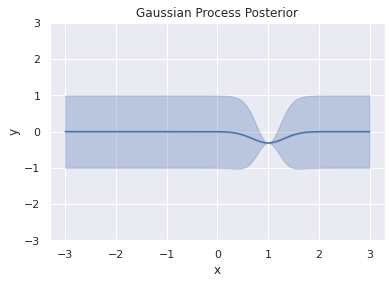

In [39]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

Lets take the $\mu$ and $\sigma$ we calcualted for $0.7$ earlier and plot the corresponding normal distribution over this plot.

In [40]:
m, s = predict(0.7, x, exponential_cov, theta, sigma_1, y)
print(m, s)

-0.19914943238544533 0.593430340259401


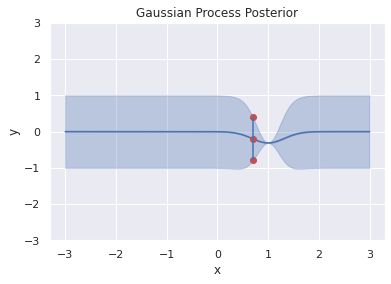

In [41]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

plt.plot(0.7, m, "ro");
plt.plot(0.7, m + s, "ro");
plt.plot(0.7, m - s, "ro");
plt.vlines(x=0.7, ymin=m-s, ymax=m+s);

Next, take another sample from one of the uncountable infinite normal distributions, say $x = -1.5$. First, let's calculate the normal distribution at $x = -1.5$

In [42]:
x_1 = -1.5
# Get the normal distribution at -1.5
m, s = predict(x_1, x, exponential_cov, theta, sigma_1, y)

# Sample the distribution to make our next observation
y_1 = np.random.normal(m, s)
print(y_1)

# Append the new data
x.append(x_1)
y.append(y_1)

# Update covariance matrix
sigma_2 = exponential_cov(x, x, theta)

0.339284706046176


In [43]:
predictions = [predict(i, x, exponential_cov, theta, sigma_2, y) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

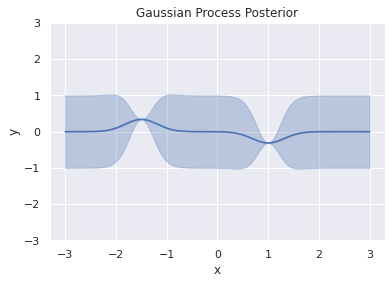

In [44]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");